# Optimal Liquidation with power law impact




In this notebook, I want to compare my solution with the one from Neuman and Jaber. Therefore, I will first copy and paste their code, such that we can use it. Their implementation is published at https://colab.research.google.com/drive/1VQasI92YhdBC0wnn_LxMkkx_45VyK1yQ and belongs to the paper Optimal Liquidation with Signals: the General Propagator Case.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## Step 2
##########
def construct_D(n,i,lamb,L,U):
    d_ti = np.zeros([n,n])
    for k in range(0,n):
        for j in range(i,n):
            d_ti[k,j] = L[k,j]
    for j in range(0,n):
        for k in range(i,n):
            d_ti[k,j] = d_ti[k,j] + U[k,j]
    return 2*lamb*np.eye(n,n) + d_ti

## Step 3
##########
#Construct a and b given U,L and R
def construct_aB_wsignal(n,lamb, U,L,tildeh, R_mat):
    B = np.zeros([n+1,n+1])
    a = np.zeros(n+1)
    for i in range(0,n+1):
        Ui = U[i,:n]
        Dti=construct_D(n,i,lamb,L,U)
        Dti_inv=np.linalg.inv(Dti)
        a[i] = - tildeh[i] + Ui@Dti_inv@tildeh[:n] + R_mat[i,i] - Ui@Dti_inv@R_mat[i,:n]    #updated
        #####
        for j in range(0,i):
            Lj = L[:n,j]
            B[i,j] = Ui@Dti_inv@Lj-L[i,j]
    return a/(2*lamb), B/(2*lamb)

## Step 4
##########
def solve_linear_Volterra(a,B):
    nn = len(a)
    return np.linalg.inv(np.eye(nn,nn)-B)@a

In [3]:
## Step 1
##########
#Simulate signal
def simulate_OU(n, dt, I_0, gamma, sigma):
    w = np.random.normal(0, 1, n)
    I = [I_0]
    e_gamma = np.exp(-gamma*dt)
    std = np.sqrt((1 - e_gamma*e_gamma)*sigma*sigma/(2*gamma))
    for k in range(n):
        I_k = e_gamma*I[k]+ std*w[k]
        I.append(I_k)
    return I

#Construct  R
def construct_condexpectation_OU(n, T, gamma, In):
    dt = T/n
    R = np.zeros([n+1,n+1])
    for i in range(0,n+1):
        exp_ni = np.exp(-gamma*(n - i)*dt)
        for k in range(i,n+1):
            exp_ki = np.exp(-gamma*(k - i)*dt)
            R[i,k] = In[i]*(exp_ni - exp_ki)/gamma
    return R

#Contruct base matrices L and U for different choices of kernels G 0, exp and frac
#for G=0 (ie no transient impact)
def construct_LU_zero(n,dt,varrho):
    L = np.zeros([n+1,n+1])
    U = np.zeros([n+1,n+1])
    for i in range(0,n+1):
        for j in range(0,i):
            L[i,j] = 2*varrho*dt
        for j in range(i,n):
            U[i,j] = 2*varrho*dt
    return L,U

#for G(t,s)=eta*exp(-meanrev*(t-s))
def construct_LU_exp(n,dt,varrho,meanrev, eta=1.):
    L = np.zeros([n+1,n+1])
    U = np.zeros([n+1,n+1])
    for i in range(0,n+1):
        for j in range(0,i):
            L[i,j] = 2*varrho*dt + (np.exp(-meanrev*dt*(i-j-1))- np.exp(-meanrev*dt*(i-j)))*eta/meanrev
        for j in range(i,n):
            U[i,j] = 2*varrho*dt + (np.exp(-meanrev*dt*(j-i))- np.exp(-meanrev*dt*(j+1-i)))*eta/meanrev
    return L,U

#for G(t,s)=c*(t-s)^{alpha-1}
def construct_LU_frac(n,dt,varrho,alpha, c=1.):
    L = np.zeros([n+1,n+1])
    U = np.zeros([n+1,n+1])
    for i in range(0,n+1):
        for j in range(0,i):
            L[i,j] = 2*varrho*dt + ((dt*(i-j))**alpha- (dt*(i-j-1))**alpha )*c/alpha
        for j in range(i,n):
            U[i,j] = 2*varrho*dt + ((dt*(j+1-i))**alpha-(dt*(j-i))**alpha)*c/alpha
    return L,U


##Main function for OU signal and three types of kernels
#compute sol with signal
def compute_solution_OUsignal(n, T, q, lamb, varrho, I_0, gamma, sigma,  alpha = 1., meanrev = 0.1, kernel='zero', signal = 'OU', seed = 1):
    dt = T/n
    tildeh = (-2*varrho*q)*np.ones(n+1)  #h0_tilde=h_0 -2*varrho*q
    t_vec = np.linspace(0,T, n + 1)

    #Construct conditional expectation matrix in presence of signal
    if signal == 'OU':
        np.random.seed(seed)
        I = simulate_OU(n, dt, I_0, gamma, sigma)
        R_mat = construct_condexpectation_OU(n, T, gamma, I)
    else:
        I = np.zeros([n+1])
        R_mat = np.zeros([n+1,n+1])

    if kernel =='exponential':
        L, U = construct_LU_exp(n,dt,varrho, meanrev)
    elif kernel =='fractional':
        L, U = construct_LU_frac(n,dt,varrho, alpha)
    else:
        L, U = construct_LU_zero(n,dt,varrho)

    a,B = construct_aB_wsignal(n,lamb, U,L,tildeh, R_mat)

    u_star = solve_linear_Volterra(a,B)
    running_inv = q-dt*np.append(0., np.cumsum(u_star)[0:n])
    transient_impact = (L-2*varrho*dt*np.tri(n+1, n+1,-1))@u_star #Compute the term Z_t = \int_0^t G(t,s)u^*_s ds

    return t_vec, u_star, running_inv, I, transient_impact
#Signal OU: dI_t = -\gamma I_t dt + \sigma dW_t
seed = 3 #random seed for signal path
I_0 = -2.
gamma = .3
sigma = .5
meanrev = 0.1

# Vergleich mit meinem Setting

Now, I implement my solution and compare it with the one from Jaber and Neuman. We will see, how the solution converges for large rho.

In [4]:
#zu erst muss c berechnet werden. dafür brauchen wir das inverse von eins
q = 20. #initial inventory
n = 200 #number of discretization points
T = 10.
lamb = 7 
eta =lamb #linear temporary impact
varrho = 0 #Penalization on terminal inventory
alpha = 0.55 #for fractional kernel: (t-s)^{alpha-1}
phi = 3
t_vec = np.linspace(0,T, n + 1)
t = np.delete(t_vec, np.s_[-1:])
Eins = np.zeros([n])
for i in range(0,n):
        Eins[i] = 1
Eins.ndim
dt = T/n

In [5]:
def construct_u(n,dt,alpha,lamb,phi, c=1.):
    L = np.zeros([n,n])
    U = np.zeros([n,n])
    for i in range(0,n):
        for j in range(0,i):
            L[i,j] =  ((dt*(i-j))**alpha- (dt*(i-j-1))**alpha )*c/alpha
        for j in range(i,n):
            U[i,j] =  ((dt*(j+1-i))**alpha-(dt*(j-i))**alpha)*c/alpha
    G = L+U
    for i in range (0,n):
        G[i,i] = G[i,i] + 2*lamb
    M_1 =  np.zeros([n,n])
    t_vec = np.linspace(0,T, n+1 )
    t = np.delete(t_vec, np.s_[-1:])
    for i in range(0,n):
        for j in range(0,i):
            M_1[i,j] = -2*phi*dt*t_vec[i]
        for j in range(i,n):
            M_1[i,j] = -2 *phi*0.5*((t_vec[j+1]*t_vec[j+1]) -(t_vec[j]*t_vec[j]))
    H= G + M_1
    H_inv=np.linalg.inv(H)
    Eins = np.zeros([n])
    for i in range(0,n):
            Eins[i] = 1
    I_1 =(T/n)*np.sum(H_inv.dot(Eins))
    I_ID = (T/n)*np.sum(H_inv.dot(t))
    S =T/n*np.sum(H_inv.dot(Eins))
    C = (q+ (2*q* phi*I_ID))/I_1
    C_vec = np.zeros([n])
    for i in range(0,n):
        C_vec[i] = C - (2*phi *q*t[i])
    u = H_inv.dot(C_vec)
    return(u)

In [6]:
def running_inv(n,dt,u):
    r = q-dt*np.append(0., np.cumsum(u)[0:(n-1)])
    return(r)

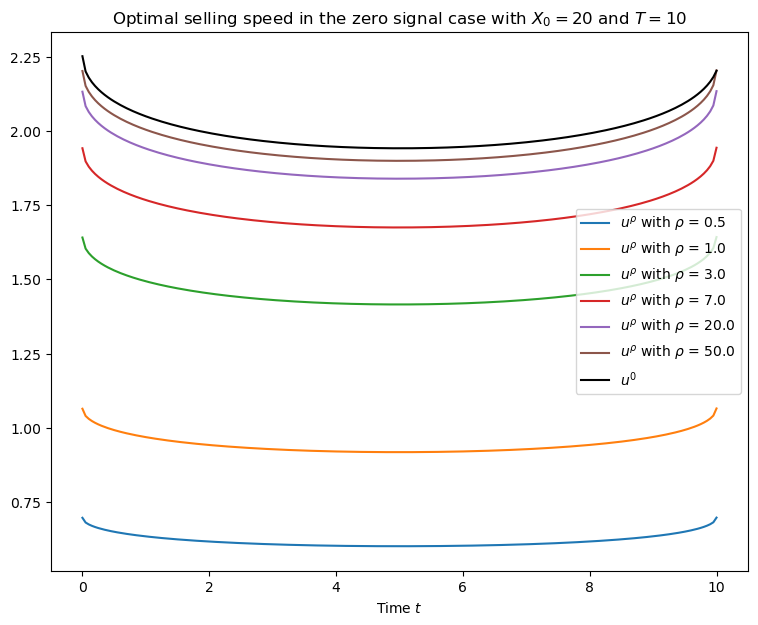

In [7]:
fig = plt.figure(figsize=(9,7))
for varrho in [0.5, 1., 3., 7.,20.,50.]:
    t_vec, u_star_frac, running_inv_frac, In_OU, _ = compute_solution_OUsignal(n, T, q, lamb, varrho, I_0, gamma, sigma,  alpha, meanrev ,'fractional', 'none', seed)
    titel = r'$u^\rho$ with $\rho$ = {}'.format(varrho)
    plt.plot(t_vec,u_star_frac, label=titel )
#plt.plot(t,u, label='$u^0$')
plt.plot(t_vec,construct_u(n+1,dt,alpha,lamb,0, c=1.), label='$u^0$',color='black')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Optimal selling speed in the zero signal case with $X_0=20$ and $T=10$')
plt.legend()
plt.savefig('Bild_Vergleich_speed')
plt.show()

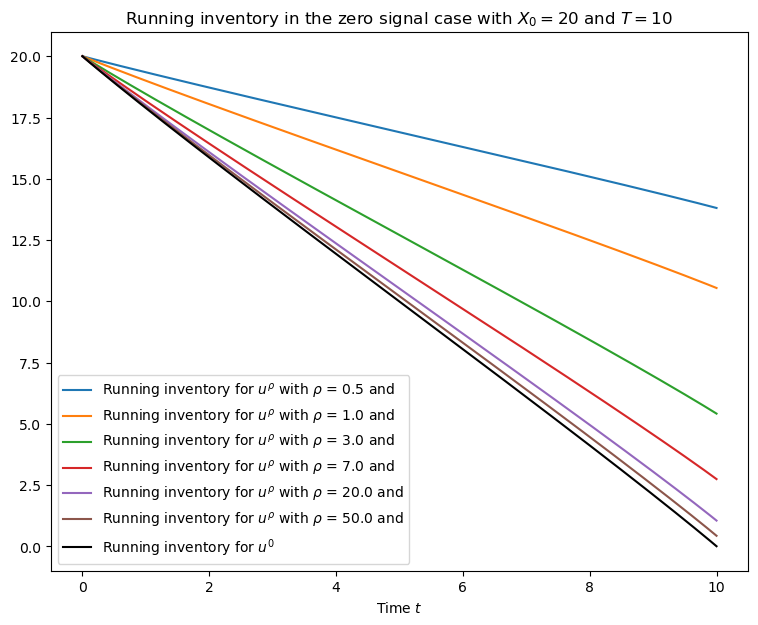

In [8]:
fig = plt.figure(figsize=(9,7))
for varrho in [0.5, 1., 3., 7.,20.,50.]:
    t_vec, u_star_frac, running_inv_frac, In_OU, _ = compute_solution_OUsignal(n, T, q, lamb, varrho, I_0, gamma, sigma,  alpha, meanrev,'fractional', 'none', seed)
    titel = r'Running inventory for $u^\rho$ with $ \rho $ = {} and'.format(varrho)
    plt.plot(t_vec,running_inv_frac, label=titel )
u= construct_u(n+1,dt,alpha,lamb,0, c=1.)
plt.plot(t_vec,running_inv(n+1,dt,u), label=r'Running inventory for $u^0$',color='black')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Running inventory in the zero signal case with $X_0=20$ and $T=10$')
plt.legend() 
plt.savefig('Bild_Vergleich_inventory')
plt.show()

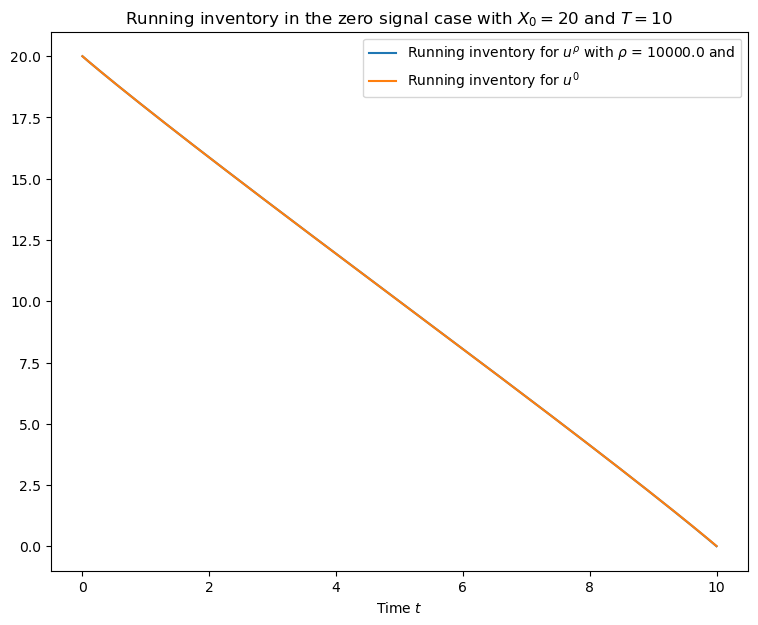

In [9]:
fig = plt.figure(figsize=(9,7))
for varrho in [10000.]:
    t_vec, u_star_frac, running_inv_frac, In_OU, _ = compute_solution_OUsignal(n, T, q, lamb, varrho, I_0, gamma, sigma,  alpha, meanrev,'fractional', 'none', seed)
    titel = r'Running inventory for $u^\rho$ with $ \rho $ = {} and'.format(varrho)
    plt.plot(t_vec,running_inv_frac, label=titel )
plt.plot(t_vec,running_inv(n+1,dt,u), label=r'Running inventory for $u^0$')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Running inventory in the zero signal case with $X_0=20$ and $T=10$')
plt.legend() 
plt.show()

In [10]:
def Value(a,q,eta,P_T,c):
    dt_1 = T/(len(a))
    a_squared = np.zeros([len(a)])
    for k in range(len(a)):
        a_squared[k] = eta*a[k]*a[k]
    S_1 = dt_1 * np.sum(a_squared)
    z = np.zeros([len(a)])
    g = np.zeros([len(a),len(a)])
    for i in range(0,len(a)):
        for j in range(0,i):
            g[i,j] = a[j]*((dt*(i-j))**alpha- (dt*(i-j-1))**alpha )*c/alpha
        z[i] = np.sum(g[i])
    S_2 = dt_1*np.sum(z)
    return(P_T*q-S_1-S_2)
    #A = dt_1*np.append(0., np.cumsum(a)[0:len(a)])

In [11]:
def Value_in_t(a,q,eta,P_T,c):
    dt_1 = T/(len(a))
    a_squared = np.zeros([len(a)])
    for k in range(len(a)):
        a_squared[k] = eta*a[k]*a[k]
    z = np.zeros([len(a)])
    g = np.zeros([len(a),len(a)])
    for i in range(0,len(a)):
        for j in range(0,i):
            g[i,j] = a[j]*((dt*(i-j))**alpha- (dt*(i-j-1))**alpha )*c/alpha
        z[i] = np.sum(g[i])*a[i]
    return(-z-a_squared)

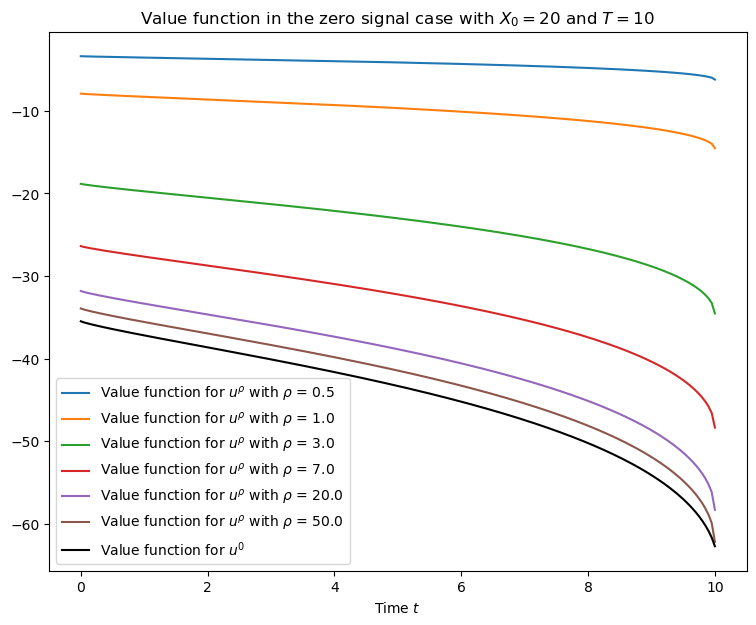

In [12]:
fig = plt.figure(figsize=(9,7))
for varrho in [0.5, 1., 3., 7.,20.,50.]:
    t_vec, u_star_frac, running_inv_frac, In_OU, _ = compute_solution_OUsignal(n, T, q, lamb, varrho, I_0, gamma, sigma,  alpha, meanrev,'fractional', 'none', seed)
    titel = r'Value function for $u^\rho$ with $ \rho $ = {}'.format(varrho)
    plt.plot(t_vec,Value_in_t(u_star_frac,q,eta,5,1), label=titel )
plt.plot(t_vec,Value_in_t(u,q,eta,5,1), label=r'Value function for $u^0$',color='black')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Value function in the zero signal case with $X_0=20$ and $T=10$')
plt.legend() 
plt.show()

# Vergleich von Risk aversion und temporary impact

In this section, we will just focus on our implemented solution. We also implemented the zero signal case with an risk aversion term. We want to compare these. For example, we can choose a large risk aversion component and see, that it approaches the strategy, where we liquidate our whole inventory directly in the beginning.

In [13]:
u_risk = construct_u(n,dt,alpha,2,phi, c=1.)
u_temp = construct_u(n,dt,alpha,lamb,0, c=1.)
u_both = construct_u(n,dt,alpha,lamb,phi, c=1.)

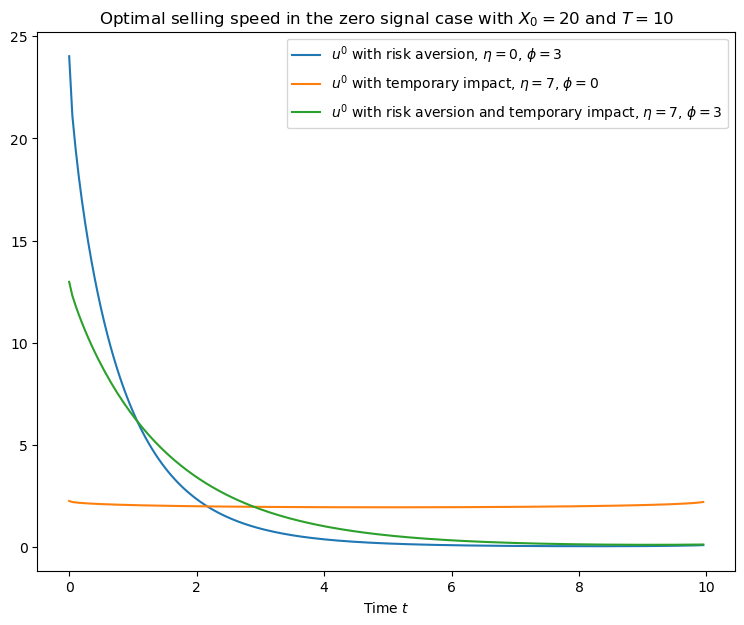

In [14]:
fig = plt.figure(figsize=(9,7))
plt.plot(t,u_risk, label=r'$u^0$ with risk aversion, $\eta =0$, $\phi = {}$'.format(phi) )
plt.plot(t,u_temp, label=r'$u^0$ with temporary impact, $\eta = {}$, $\phi =0$'.format(lamb))
plt.plot(t,u_both, label=r'$u^0$ with risk aversion and temporary impact, $\eta = {}$, $\phi ={}$'.format(lamb,phi))
plt.legend()
plt.xlabel(r'Time $t$')
plt.title(r'Optimal selling speed in the zero signal case with $X_0=20$ and $T=10$')
plt.savefig('Bild_speed_3var')
plt.show()

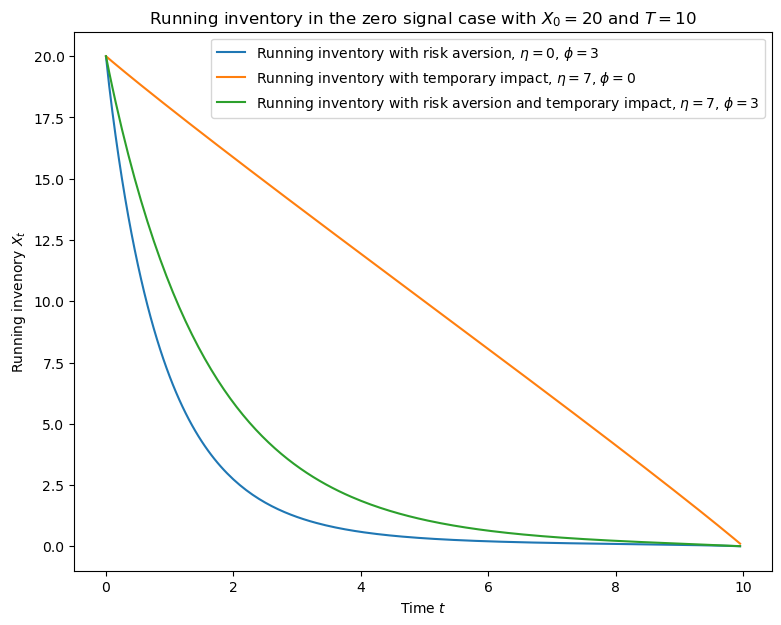

In [15]:
fig = plt.figure(figsize=(9,7))
plt.plot(t,running_inv(n,dt,u_risk), label=r'Running inventory with risk aversion, $\eta =0$, $\phi = {}$'.format(phi) )
plt.plot(t,running_inv(n,dt,u_temp), label=r'Running inventory with temporary impact, $\eta = {}$, $\phi =0$'.format(lamb))
plt.plot(t,running_inv(n,dt,u_both), label=r'Running inventory with risk aversion and temporary impact, $\eta = {}$, $\phi ={}$'.format(lamb,phi))
plt.legend()
plt.xlabel(r'Time $t$')
plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Running inventory in the zero signal case with $X_0=20$ and $T=10$')
plt.savefig('Bild_inv_3var')
plt.show()

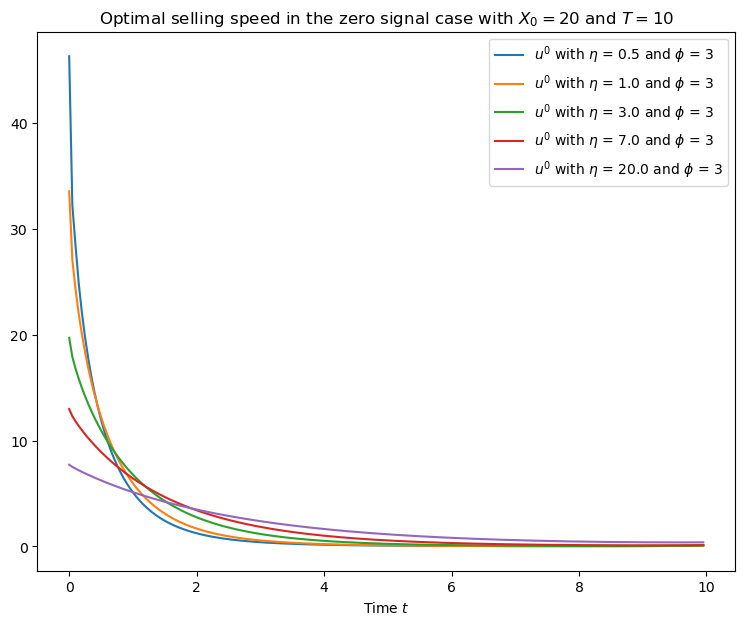

In [16]:
fig = plt.figure(figsize=(9,7))
for vareta in [0.5, 1., 3., 7.,20.]:
    u = construct_u(n,dt,alpha,vareta,phi, c=1.)
    titel = r'$u^0$ with $\eta$ = {} and $\phi$ = {}'.format(vareta,phi)
    plt.plot(t,u, label=titel )
#plt.plot(t,u, label='$u^0$')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Optimal selling speed in the zero signal case with $X_0=20$ and $T=10$')
plt.legend()
plt.show()

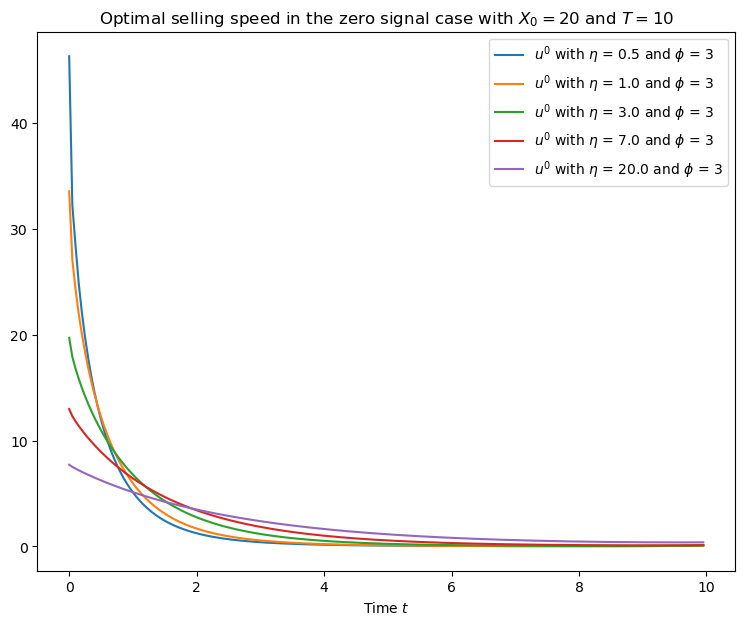

In [17]:
fig = plt.figure(figsize=(9,7))
for vareta in [0.5, 1., 3., 7.,20.]:
    u = construct_u(n,dt,alpha,vareta,phi, c=1.)
    titel = r'$u^0$ with $\eta$ = {} and $\phi$ = {}'.format(vareta,phi)
    plt.plot(t,u, label=titel )
#plt.plot(t,u, label='$u^0$')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Optimal selling speed in the zero signal case with $X_0=20$ and $T=10$')
plt.legend()
plt.show()

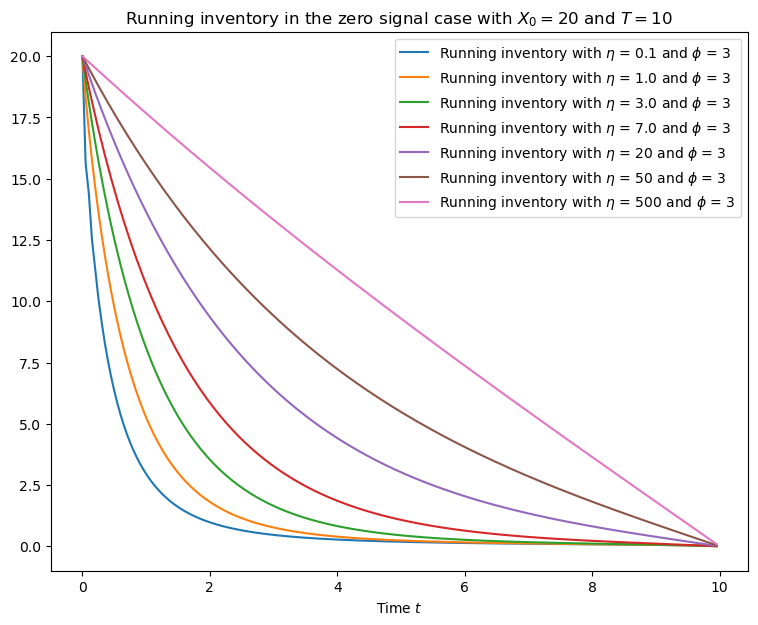

In [18]:
fig = plt.figure(figsize=(9,7))
for vareta in [0.1, 1., 3., 7.,20,50,500]:
    u = construct_u(n,dt,alpha,vareta,phi, c=1.)
    titel = r'Running inventory with $\eta$ = {} and $\phi$ = {}'.format(vareta,phi)
    plt.plot(t,running_inv(n,dt,u), label=titel )
#plt.plot(t,u, label='$u^0$')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Running inventory in the zero signal case with $X_0=20$ and $T=10$')
plt.legend()
plt.show()

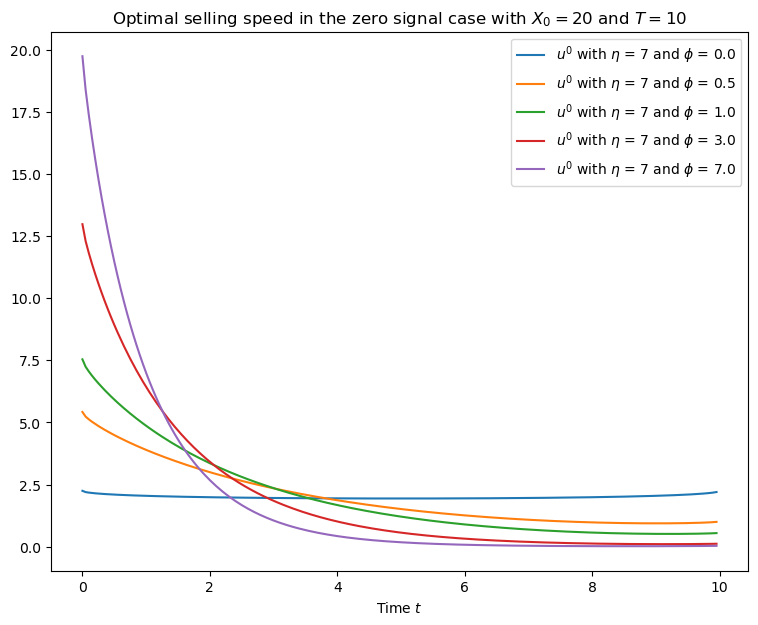

In [19]:
fig = plt.figure(figsize=(9,7))
for varphi in [0.,0.5, 1., 3., 7.]:
    u = construct_u(n,dt,alpha,eta,varphi, c=1.)
    titel = r'$u^0$ with $\eta$ = {} and $\phi$ = {}'.format(eta,varphi)
    plt.plot(t,u, label=titel )
#plt.plot(t,u, label='$u^0$')
plt.xlabel(r'Time $t$')
#plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Optimal selling speed in the zero signal case with $X_0=20$ and $T=10$')
plt.legend()
plt.savefig('Bild_speed_varphi')
plt.show()

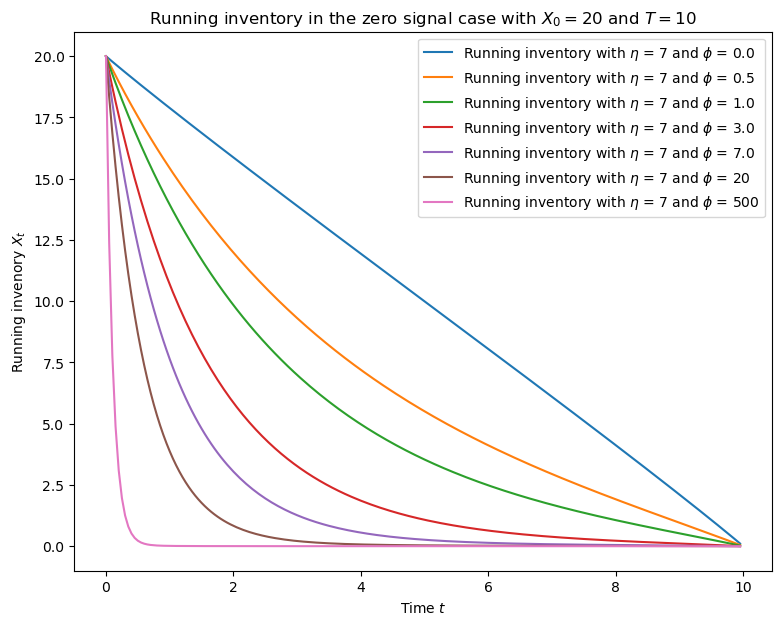

In [20]:
fig = plt.figure(figsize=(9,7))
for varphi in [0.,0.5, 1., 3., 7.,20,500]:
    u = construct_u(n,dt,alpha,eta,varphi, c=1.)
    titel = r'Running inventory with $\eta$ = {} and $\phi$ = {}'.format(eta,varphi)
    plt.plot(t,running_inv(n,dt,u), label=titel )
#plt.plot(t,u, label='$u^0$')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Running invenory $X_t$')
plt.title(r'Running inventory in the zero signal case with $X_0=20$ and $T=10$')
plt.legend()
plt.savefig('Bild_inv_varphi')
plt.show()